# <hr>
<h1><center> Analyse de sentiments sur des tweets</center></h1>

<hr>
<h2><center>Modèle avancé BERT</center></h2>
<br>

>__Réalisé par : Said Arrazouaki__


>__email : sarrazouaki@gmail.com__

# Approche 3 – Modèle BERT (Transformer)

Pour compléter l’analyse comparative, nous avons mis en œuvre un modèle de type Transformer, en utilisant BERT (Bidirectional Encoder Representations from Transformers). Ce modèle, pré-entraîné sur un grand corpus de texte (Wikipedia, livres, etc.), est reconnu pour sa compréhension fine du langage naturel, notamment grâce à son mécanisme d’attention bidirectionnelle.


**Implémentation avec Hugging Face**

Nous avons utilisé la librairie Transformers de Hugging Face, qui permet de charger facilement des modèles BERT pré-entraînés et de les adapter à une tâche spécifique comme la classification de sentiments.

Le modèle utilisé : bert-base-uncased, fine-tuné sur notre jeu de données.

**Étapes de traitement**

1. Prétraitement avec BertTokenizer

- Tokenisation avec ajout de tokens spéciaux [CLS], [SEP]

- Tronquage ou padding à une longueur fixe

- Encodage en input_ids, attention_mask, token_type_ids

2. Fine-tuning

- Utilisation de TFBertForSequenceClassification (pour classification binaire)

- Optimiseur Adam avec learning rate ajusté

- Entraînement sur 3 époques

- Tracking avec MLFlow pour logs, métriques et modèles

In [ ]:
import re
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer
import tensorflow as tf

from transformers import AdamWeightDecay
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from transformers import TFBertForSequenceClassification

In [ ]:
# Se connecter a drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
path = '/content/drive/MyDrive/Openclassrooms/Projet-7/'
sys.path.append(path)

In [ ]:
from utils import preprocess_tweet_bert

In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.2/700.2 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.1 MB/s eta 0:00:00


In [ ]:
import mlflow
import mlflow.tensorflow
from mlflow.models.signature import infer_signature

# Utiliser un dossier temporaire local (propre, sans Google Drive)
mlflow_tracking_dir = "/content/drive/MyDrive/Openclassrooms/Projet-7/mlruns"
os.makedirs(mlflow_tracking_dir, exist_ok=True)

mlflow.set_tracking_uri(f"file:{mlflow_tracking_dir}")

In [ ]:
path = '/content/drive/MyDrive/Openclassrooms/Projet-7/'

In [ ]:
df = pd.read_csv(path+'data/data_clean.csv')

In [ ]:
df.head(2)

,tweet,clean_tweet,clean_tweet_bert,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that' bummer shoulda got david carr third...,"@switchfoot [URL] - awww, that's a bummer. you...",0
1,is upset that he can't update his Facebook by ...,upset can't updat facebook text ... might cri ...,is upset that he can't update his facebook by ...,0


In [ ]:
df = df[['clean_tweet_bert', 'target']]

In [ ]:
df.head(2)

,clean_tweet_bert,target
0,"@switchfoot [URL] - awww, that's a bummer. you...",0
1,is upset that he can't update his facebook by ...,0


In [ ]:
df.isna().sum()

,0
clean_tweet_bert,0
target,0


In [ ]:
df.duplicated().sum()

np.int64(22344)

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(1577656, 2)

## Entraînement du modèle

In [ ]:
# Sélection des données
X = df['clean_tweet_bert']
y = df['target']

In [ ]:
# Découpage du dataset : train (80%) / validation (10%) / test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Taille - Entraînement : {len(X_train)} | Validation : {len(X_val)} | Test : {len(X_test)}")

Taille - Entraînement : 1262124 | Validation : 157766 | Test : 157766


In [ ]:
# Chargement du tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Conversion des séries pandas en listes
X_train = X_train.tolist()
X_val = X_val.tolist()
X_test = X_test.tolist()

In [ ]:
# Tokenisation avec troncature et remplissage
max_len = 128
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_len)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=max_len)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=max_len)

In [ ]:
# Exemple illustratif de tokenisation
example = X_train[0]
tokens = tokenizer.tokenize(example)
ids = tokenizer.encode(example)
print(f"Exemple de tweet : {example}")
print(f"Tokens : {tokens}")
print(f"IDs : {ids}")

Exemple de tweet : @jessicalynn[NUMBER] i'm so jealous! i woulkd love to get a mani/pedi right now. its been at least a year since my last one.
Tokens : ['@', 'jessica', '##lynn', '[', 'number', ']', 'i', "'", 'm', 'so', 'jealous', '!', 'i', 'wo', '##ul', '##k', '##d', 'love', 'to', 'get', 'a', 'mani', '/', 'pe', '##di', 'right', 'now', '.', 'its', 'been', 'at', 'least', 'a', 'year', 'since', 'my', 'last', 'one', '.']
IDs : [101, 1030, 8201, 27610, 1031, 2193, 1033, 1045, 1005, 1049, 2061, 9981, 999, 1045, 24185, 5313, 2243, 2094, 2293, 2000, 2131, 1037, 23624, 1013, 21877, 4305, 2157, 2085, 1012, 2049, 2042, 2012, 2560, 1037, 2095, 2144, 2026, 2197, 2028, 1012, 102]


In [ ]:
# Création des jeux de données TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test))

In [ ]:
# Paramétrage du batch et prétraitement
batch_size = 32
train_dataset = train_dataset.shuffle(len(y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Inspection d’un batch
batch = next(iter(train_dataset))
print("Clés du batch :", batch[0].keys())
print("Dimensions input_ids :", batch[0]['input_ids'].shape)
print("Dimensions labels :", batch[1].shape)

Clés du batch : dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Dimensions input_ids : (32, 128)
Dimensions labels : (32,)


In [ ]:
# Chargement du modèle BERT préentraîné pour classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Définition de l'optimiseur, perte et métriques
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

# Compilation du modèle
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Configuration de l'expérience MLflow
mlflow.set_experiment("BERT tweet classifier")

with mlflow.start_run(run_name="BERT fine-tuning") as run:
    epochs = 3
    batch_size = 32

    # Entraînement du modèle
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs
    )

    # Prédiction et extraction des logits
    y_pred_logits = model.predict(test_dataset)
    logits = y_pred_logits[0] if isinstance(y_pred_logits, (tuple, list)) else getattr(y_pred_logits, "logits", y_pred_logits)
    y_pred_labels = np.argmax(logits, axis=1)

    # Calcul des métriques
    acc = accuracy_score(y_test, y_pred_labels)
    prec = precision_score(y_test, y_pred_labels)
    rec = recall_score(y_test, y_pred_labels)
    f1 = f1_score(y_test, y_pred_labels)

    # --- Log des hyperparamètres ---
    mlflow.log_param("model_type", "BERT")
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("tokenizer", "bert-base-uncased")
    mlflow.log_param("max_len", max_len)

    # --- Log des métriques ---
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)

    # --- Ajout de tags descriptifs ---
    mlflow.set_tag("architecture", "BERT")
    mlflow.set_tag("framework", "TensorFlow")
    mlflow.set_tag("dataset", "Sentiment140")
    import warnings
    import logging
    warnings.filterwarnings("ignore", category=UserWarning)
    logging.getLogger("mlflow").setLevel(logging.ERROR)

    # --- Log du modèle TensorFlow ---
    mlflow.tensorflow.log_model(
        model,
        artifact_path="bert_model",
        signature=None,
        registered_model_name="BERT_HuggingFace"
    )

    print(f"Modèle loggué avec MLflow")

Epoch 1/3
39442/39442 [==============================] - 4121s 104ms/step - loss: 0.3318 - accuracy: 0.8560 - val_loss: 0.3116 - val_accuracy: 0.8681
Epoch 2/3
39442/39442 [==============================] - 4089s 104ms/step - loss: 0.2738 - accuracy: 0.8850 - val_loss: 0.3072 - val_accuracy: 0.8703
Epoch 3/3
4931/4931 [==============================] - 185s 37ms/step


Registered model 'BERT_HuggingFace' already exists. Creating a new version of this model...


Modèle loggué avec MLflow


Created version '2' of model 'BERT_HuggingFace'.


In [ ]:
# Évaluation finale sur le jeu de test
loss, acc = model.evaluate(test_dataset)
print(f"Résultats test - Loss : {loss:.4f} | Accuracy : {acc:.4f}")

4931/4931 [==============================] - 185s 38ms/step - loss: 0.3165 - accuracy: 0.8690
Résultats test - Loss : 0.3165 | Accuracy : 0.8690


In [ ]:
# Rapport de classification
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_test, y_pred_labels, target_names=["Négatif", "Positif"]))
print("F1-score global (pondéré) :", f1_score(y_test, y_pred_labels, average='weighted'))

              precision    recall  f1-score   support

     Négatif       0.88      0.86      0.87     78794
     Positif       0.86      0.88      0.87     78972

    accuracy                           0.87    157766
   macro avg       0.87      0.87      0.87    157766
weighted avg       0.87      0.87      0.87    157766

F1-score global (pondéré) : 0.8689446373953326


In [ ]:
# Sauvegarde du modèle et tokenizer
save_directory = "/content/drive/MyDrive/Openclassrooms/Projet-7/bert_entraine"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/Openclassrooms/Projet-7/bert_entraine/tokenizer_config.json',
 '/content/drive/MyDrive/Openclassrooms/Projet-7/bert_entraine/special_tokens_map.json',
 '/content/drive/MyDrive/Openclassrooms/Projet-7/bert_entraine/vocab.txt',
 '/content/drive/MyDrive/Openclassrooms/Projet-7/bert_entraine/added_tokens.json')

## Prédire le sentiment d’un nouveau tweet

In [ ]:
# Chargement du modèle
from transformers import TFBertForSequenceClassification, BertTokenizer

save_directory = "/content/drive/MyDrive/Openclassrooms/Projet-7/bert_entraine"

model = TFBertForSequenceClassification.from_pretrained(save_directory)
tokenizer = BertTokenizer.from_pretrained(save_directory)

Some layers from the model checkpoint at /content/drive/MyDrive/Openclassrooms/Projet-7/bert_entraine were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Openclassrooms/Projet-7/bert_entraine.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further

In [ ]:
import tensorflow as tf

def predire_sentiment(tweet):
    """Prédit le sentiment d'un tweet donné (texte brut)."""

    # process the tweet for bert
    tweet = preprocess_tweet_bert(tweet)
    # Tokenization du tweet
    inputs = tokenizer(tweet, return_tensors='tf', truncation=True, padding=True, max_length=128)
    # Passage dans le modèle pour obtenir les logits
    outputs = model(**inputs)
    logits = outputs.logits
    # Conversion en probabilités avec softmax
    probs = tf.nn.softmax(logits, axis=1)[0].numpy()
    # Classe prédite (0 ou 1)
    pred_class = int(tf.argmax(logits, axis=1)[0])
    sentiment_str = "Positif 😀" if pred_class == 1 else "Négatif 🙁"
    print(f"Tweet : {tweet}")
    print(f"Sentiment prédit : {sentiment_str} (confiance = {probs[pred_class]*100:.1f}%)")


In [ ]:
tweet1 = "a great film"
tweet2 = "very bad one!! "
predire_sentiment(tweet1)
predire_sentiment(tweet2)

Tweet : a great film
Sentiment prédit : Positif 😀 (confiance = 97.6%)
Tweet : very bad one!!
Sentiment prédit : Négatif 🙁 (confiance = 98.8%)


# Comparaison des modèles

Nous avons testé plusieurs approches de classification pour détecter les sentiments des tweets sur l’ensemble de test (données jamais vues pendant l'entraînement). Le tableau suivant synthétise les performances obtenues par chaque modèle en termes d’accuracy (précision) :

| Modèle                                | Accuracy |
|--------------------------------------|----------|
| Régression logistique (Baseline)     | 0.77     |
| LSTM (Embedding appris)              | 0.79     |
| LSTM (Embedding pré-entraîné GloVe)  | 0.76     |
| Modèle avancé BERT                   | 0.87     |


Nous observons clairement que le modèle basé sur BERT obtient la meilleure performance avec une accuracy de 0.87, suivi par le modèle LSTM avec embedding appris (accuracy 0.79). Le modèle LSTM avec embedding pré-entraîné (GloVe) obtient des résultats légèrement inférieurs (0.76), indiquant qu’un embedding générique pré-entraîné n'est pas forcément meilleur dans ce contexte précis. Enfin, la régression logistique, modèle de référence simple, présente une performance de base correcte (0.77), mais limitée en raison de sa simplicité.

Visualisation des résultats :
Voici une représentation graphique permettant de mieux visualiser ces différences :

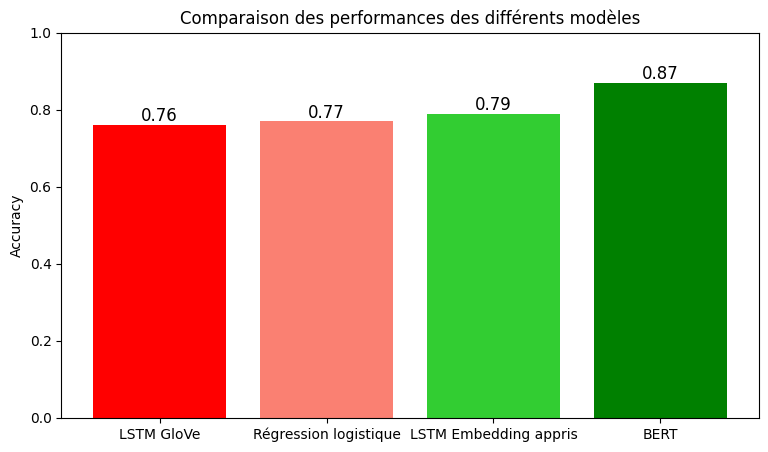

In [ ]:
import matplotlib.pyplot as plt

modeles = ['LSTM GloVe', 'Régression logistique', 'LSTM Embedding appris', 'BERT']
accuracy = [0.76, 0.77, 0.79, 0.87]

plt.figure(figsize=(9,5))
plt.bar(modeles, accuracy, color=['red', 'salmon', 'limegreen', 'green'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Comparaison des performances des différents modèles')
for index, value in enumerate(accuracy):
    plt.text(index, value + 0.01, f"{value:.2f}", ha='center', fontsize=12)
plt.show()

Ce graphique confirme nettement la supériorité du modèle BERT pour cette tâche spécifique d'analyse des sentiments des tweets.

# Conclusion

Dans ce projet, nous avons exploré plusieurs approches pour la classification des sentiments sur des données Twitter (Sentiment140). Après avoir comparé différents modèles allant de la régression logistique jusqu'à un modèle Transformer avancé (BERT), nous constatons que le modèle BERT obtient clairement les meilleures performances avec une accuracy remarquable de 87%.

Le choix du modèle BERT est justifié par :

Sa capacité à capturer les subtilités linguistiques et contextuelles mieux que les approches classiques comme les LSTM.

Une meilleure généralisation sur des données non vues, essentielle pour des cas réels.

🔧 Déploiement futur du modèle BERT :
Compte tenu de ces résultats convaincants, nous allons poursuivre notre projet en vue d'un déploiement en production du modèle BERT via une API REST hébergée sur une plateforme Cloud (par exemple Azure App Service ou Heroku). Ce modèle permettra ainsi à des utilisateurs finaux d’obtenir instantanément des prédictions fiables sur le sentiment de nouveaux tweets.

📌 Limitations et points d'attention :
Bien que performant, le modèle BERT présente certaines contraintes à prendre en compte lors du déploiement :

Temps et coût d'entraînement élevés comparés aux modèles classiques.

Nécessité de ressources GPU en production pour assurer des performances optimales (temps de réponse rapide pour l'utilisateur).

Malgré ces défis techniques, les avantages apportés par BERT en termes de précision justifient pleinement son choix.

🚀 Prochaines étapes :
Mise en place d'un pipeline MLOps pour le suivi et le monitoring du modèle en production (MLflow, Application Insights).

Développement d'une interface utilisateur simple pour valider les prédictions en temps réel.

Collecte de retours utilisateurs pour continuellement réentraîner et améliorer notre modèle.

En conclusion, le modèle BERT apparaît comme une solution robuste, fiable et prometteuse pour l'analyse automatisée des sentiments des tweets. Ce choix stratégique permet d’envisager des applications réelles performantes et évolutives dans le domaine du traitement automatique du langage naturel (NLP).